# Analyse des Composantes Principales

D'apr√®s les conclusions de l'analyse exploiration des donn√©es (2_EDA_Amazing.ipynb) section pr√©c√©dentes
Les variables num√©riques retenues qui semblent les plus pertinentes pour r√©aliser une ACP

`total_purchase_value` : Indique la valeur totale des achats, ce qui est crucial pour comprendre la valeur mon√©taire des segments.
`number_of_sessions_7m` ou `number_of_views_7m` : Mesure la fr√©quence d'utilisation, un indicateur de l'engagement utilisateur.
`days_since_last_purchase`: Donne une id√©e de la r√©tention ou de l'inactivit√©, essentiel pour √©valuer la fid√©lit√©.


In [18]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np




# Lire le fichier Parquet
df = pd.read_parquet("data/user_stats_df_output.parquet")


In [19]:


# Calcul du nombre total d'achats en utilisant la valeur totale des achats divis√©e par le prix moyen sur 7 mois
df['total_purchases'] = df['total_purchase_value'] / df['avg_price_7m']
df['total_purchases'] = df['total_purchases'].fillna(0).astype(int)  # Conversion en entier et gestion des NaN


In [20]:
df.columns

Index(['user_id', 'number_of_views_2m', 'number_of_carts_2m',
       'number_of_sessions_2m', 'count_products_2m', 'avg_price_2m',
       'number_of_views_5m', 'number_of_carts_5m', 'number_of_sessions_5m',
       'count_products_5m', 'avg_price_5m', 'number_of_views_7m',
       'number_of_carts_7m', 'number_of_sessions_7m', 'count_products_7m',
       'avg_price_7m', 'last_purchase', 'days_since_last_purchase',
       'total_purchase_value', 'cart_abandonments', 'preferred_brand',
       'preferred_category', 'most_active_time', 'most_active_day',
       'total_purchases'],
      dtype='object')

In [21]:
# Calcul de la valeur moyenne d'achat, √©vite la division par z√©ro en utilisant np.where
df['avg_purchase_value'] = np.where(df['total_purchases'] > 0, df['total_purchase_value'] / df['total_purchases'], 0)


In [22]:
# Calcul du taux de conversion en pourcentage
df['conversion_rate'] = np.where(df['number_of_carts_7m'] > 0, df['total_purchases'] / df['number_of_carts_7m'], 0)

In [23]:
# Supposons une p√©riode d'observation de 30 jours (1 mois environ)
observation_period_days = 30
df['purchase_frequency'] = df['total_purchases'] / observation_period_days

In [24]:
# Calcul d'un score de fid√©lit√© simplifi√©
df['loyalty_score'] = (df['purchase_frequency'] * 0.5) + (df['avg_purchase_value'] * 0.3) - (df['days_since_last_purchase'] * 0.2)


In [25]:
df.columns

Index(['user_id', 'number_of_views_2m', 'number_of_carts_2m',
       'number_of_sessions_2m', 'count_products_2m', 'avg_price_2m',
       'number_of_views_5m', 'number_of_carts_5m', 'number_of_sessions_5m',
       'count_products_5m', 'avg_price_5m', 'number_of_views_7m',
       'number_of_carts_7m', 'number_of_sessions_7m', 'count_products_7m',
       'avg_price_7m', 'last_purchase', 'days_since_last_purchase',
       'total_purchase_value', 'cart_abandonments', 'preferred_brand',
       'preferred_category', 'most_active_time', 'most_active_day',
       'total_purchases', 'avg_purchase_value', 'conversion_rate',
       'purchase_frequency', 'loyalty_score'],
      dtype='object')

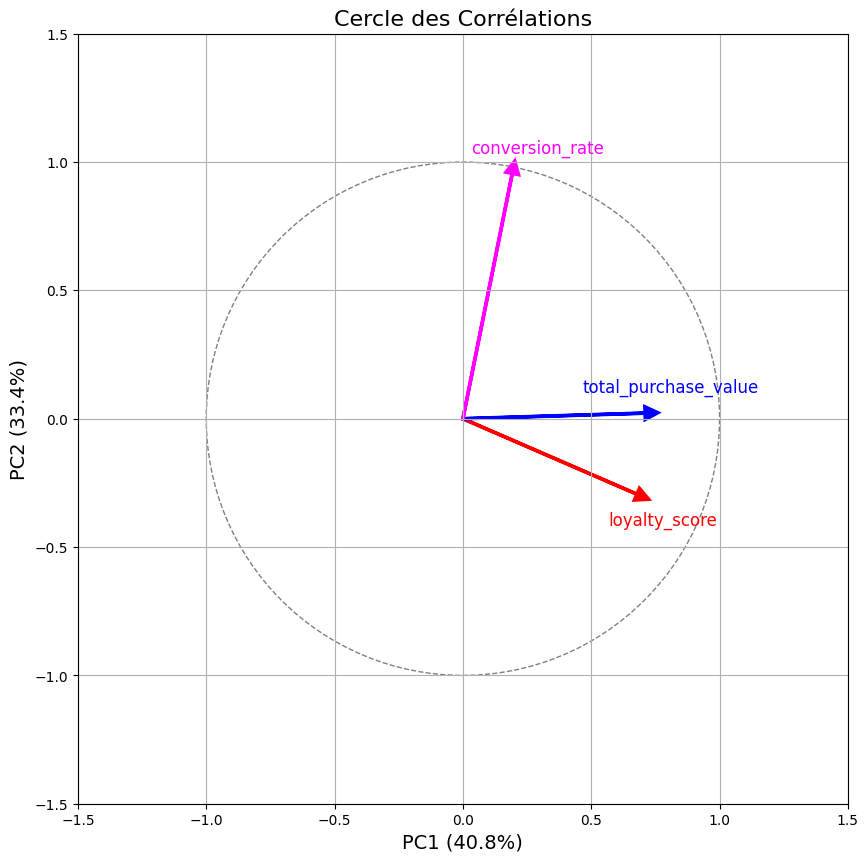

Variance expliqu√©e par PC1: 40.81%
Variance expliqu√©e par PC2: 33.45%


In [26]:

# S√©lection des colonnes pour l'ACP
variables_acp = [
    # 'total_purchase_value', 'number_of_sessions_7m', 'count_products_7m',
    # 'number_of_carts_7m', 'total_purchases', 'avg_purchase_value',
    # 'conversion_rate', 'purchase_frequency', 'loyalty_score'
    'loyalty_score','total_purchase_value',
    'conversion_rate'
]

# V√©rifiez que toutes les colonnes s√©lectionn√©es sont bien pr√©sentes
missing_columns = [col for col in variables_acp if col not in df.columns]
if missing_columns:
    print(f"Colonnes manquantes : {missing_columns}")
else:
    # Extraction des donn√©es pour les variables s√©lectionn√©es
    X = df[variables_acp]

    # Standardisation des donn√©es
    X_standardized = StandardScaler().fit_transform(X)

    # R√©alisation de l'ACP
    pca = PCA(n_components=2)  # Nous prenons 2 composantes principales pour la visualisation
    principal_components = pca.fit_transform(X_standardized)

    # Fonction pour afficher le cercle des corr√©lations
    def plot_correlation_circle(pca, components, features, ax=None):
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 10))

        # Dessin du cercle
        circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--', linewidth=1)
        ax.add_artist(circle)

        # Couleurs distinctes pour chaque fl√®che
        colors = ['red', 'blue', 'magenta', 'orange', 'brown', 'green', 'purple', 'cyan', 'black']

        # Boucle pour afficher les vecteurs et labels
        for i in range(len(features)):
            ax.arrow(0, 0, components[i, 0], components[i, 1], 
                     head_width=0.05, head_length=0.05, linewidth=2.5, color=colors[i % len(colors)])
            
            # Positionnement conditionnel des labels pour √©viter les chevauchements
            offset_x = 0.1 if components[i, 0] > 0 else -0.1
            offset_y = 0.1 if components[i, 1] > 0 else -0.1
            
            ax.text(components[i, 0] + offset_x, components[i, 1] + offset_y, 
                    features[i], ha='center', va='center', fontsize=12, color=colors[i % len(colors)])

        ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%})", fontsize=14)
        ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%})", fontsize=14)
        ax.set_title('Cercle des Corr√©lations', fontsize=16)
        ax.grid(True)
        ax.set_xlim(-1.5, 1.5)
        ax.set_ylim(-1.5, 1.5)
        ax.set_aspect('equal')

    # Calcul des composantes principales
    components = pca.components_.T

    # Affichage du cercle de corr√©lation
    plot_correlation_circle(pca, components, variables_acp)
    plt.show()

    # Afficher l'explication des composantes principales
    explained_variance = pca.explained_variance_ratio_
    print(f"Variance expliqu√©e par PC1: {explained_variance[0]:.2%}")
    print(f"Variance expliqu√©e par PC2: {explained_variance[1]:.2%}")



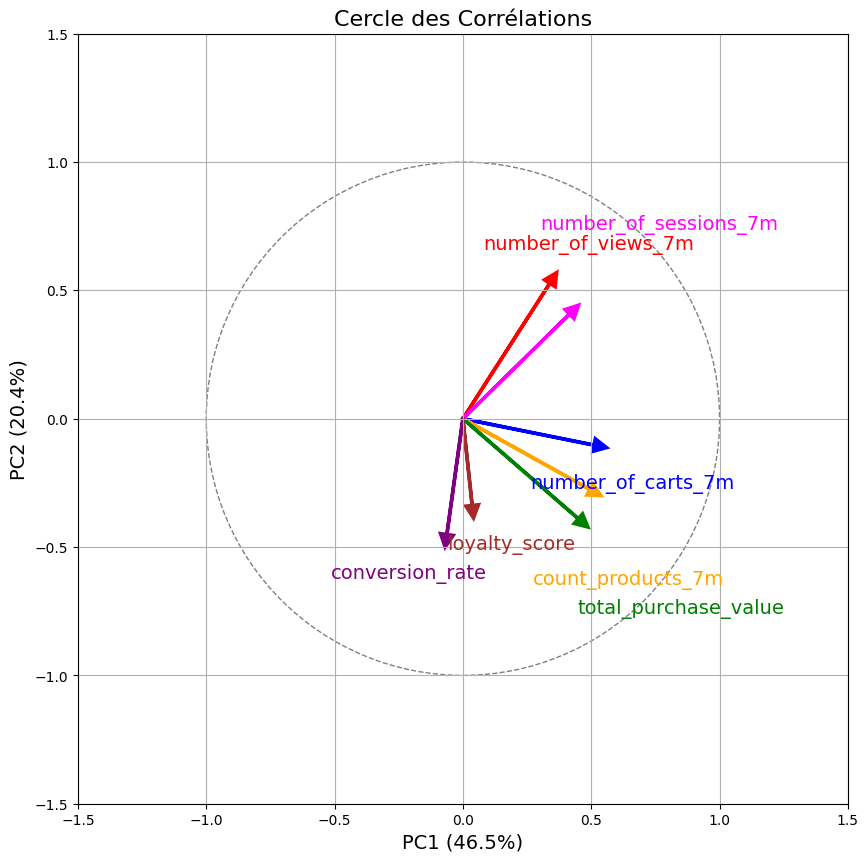

Variance expliqu√©e par PC1: 46.51%
Variance expliqu√©e par PC2: 20.44%


In [27]:

# # Lecture du fichier parquet
# df = pd.read_parquet("data/user_stats_df_output.parquet")

# # V√©rification des colonnes disponibles dans le DataFrame
# print(df.columns)

# S√©lection des colonnes pertinentes pour l'ACP
# Suppression de 'total_purchases' car elle n'est pas pr√©sente
# variables_acp = [
#     # 'total_purchase_value', 'number_of_views_7m',
#     # 'count_products_7m', 'number_of_carts_7m'
#     'number_of_views_7m',
#     'number_of_carts_7m', 'number_of_sessions_7m', 'count_products_7m',
#     'days_since_last_purchase','total_purchase_value', 'cart_abandonments'
# ]


# S√©lection des variables pour l'ACP
variables_acp = [
    'number_of_views_7m',
    'number_of_carts_7m', 'number_of_sessions_7m', 'count_products_7m',
    'loyalty_score', 'total_purchase_value',
    'conversion_rate'
]

# Extraction des donn√©es pour les variables s√©lectionn√©es
X = df[variables_acp]

# Standardisation des donn√©es
X_standardized = StandardScaler().fit_transform(X)

# R√©alisation de l'ACP
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_standardized)

# Fonction pour afficher le cercle des corr√©lations avec un ajustement des labels
def plot_correlation_circle(pca, components, features, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))

    # Dessin du cercle
    circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--', linewidth=1)
    ax.add_artist(circle)

    # Couleurs pour les fl√®ches (ajust√© le nombre de couleurs)
    colors = ['red', 'blue', 'magenta', 'orange', 'brown', 'green', 'purple'] 

    # Boucle pour afficher les vecteurs et labels
    for i in range(len(features)):
        ax.arrow(0, 0, components[i, 0], components[i, 1], 
                 head_width=0.05, head_length=0.05, linewidth=2.5, color=colors[i])
        
        # Positionnement conditionnel des labels pour √©viter les chevauchements
        offset_x = 0.15 if components[i, 0] > 0 else -0.15
        offset_y = 0.15 if components[i, 1] > 0 else -0.15

        # Ajustement sp√©cifique pour les √©tiquettes probl√©matiques
        if features[i] == 'count_products_7m':
            offset_y -= 0.2
        elif features[i] == 'total_purchase_value':
            offset_x += 0.25
            offset_y -= 0.2
        elif features[i] == 'number_of_sessions_7m':
            offset_x += 0.2
            offset_y += 0.2
        
        ax.text(components[i, 0] + offset_x, components[i, 1] + offset_y, 
                features[i], ha='center', va='center', fontsize=14, color=colors[i])

    ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%})", fontsize=14)
    ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%})", fontsize=14)
    ax.set_title('Cercle des Corr√©lations', fontsize=16)
    ax.grid(True)
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.set_aspect('equal')

# Calcul des composantes principales
components = pca.components_.T

# Affichage du cercle de corr√©lation
plot_correlation_circle(pca, components, variables_acp)
plt.show()

# Affichage de la variance expliqu√©e par les deux premi√®res composantes
explained_variance = pca.explained_variance_ratio_
if len(explained_variance) >= 2:
    print(f"Variance expliqu√©e par PC1: {explained_variance[0]:.2%}")
    print(f"Variance expliqu√©e par PC2: {explained_variance[1]:.2%}")
else:
    print("La variance expliqu√©e par les composantes principales n'est pas suffisante.")



Les variables contribuent le plus √† expliquer la variance dans les donn√©es. Voici les variables les plus influentes, d'apr√®s le cercle des corr√©lations.

1. **`number_of_views_7m` et `number_of_sessions_7m`** (fl√®ches rouge et magenta) :
   - Ces variables sont align√©es le long de la composante PC1, ce qui indique qu'elles ont une contribution significative pour expliquer cette composante principale. Elles sont li√©es aux comportements d'engagement des utilisateurs sur la plateforme.

2. **`total_purchase_value`** (fl√®che verte) :
   - Positionn√©e principalement sur PC1, cette variable est essentielle pour comprendre les comportements d'achat des clients. Elle indique que la valeur totale des achats est une dimension cl√©.

3. **`loyalty_score` et `conversion_rate`** (fl√®ches marron et violet) :
   - Bien que moins √©tendues, ces fl√®ches indiquent des contributions importantes, surtout en corr√©lation avec PC2. Elles sont pertinentes pour capturer la fid√©lit√© des clients et l'efficacit√© de leurs interactions sur le site.

4. **`number_of_carts_7m` et `count_products_7m`** (fl√®ches bleu et orange) :
   - Ces variables ont une contribution mod√©r√©e mais restent proches des axes principaux, ce qui indique leur pertinence pour l'analyse des comportements li√©s aux ajouts au panier et √† la consultation de produits.

### Variables √† Retenir :
- **`number_of_views_7m`**
- **`number_of_sessions_7m`**
- **`total_purchase_value`**
- **`loyalty_score`**
- **`conversion_rate`**

Ces variables capturent les principales dimensions des comportements d'engagement, d'achat, et de fid√©lit√© des clients, et sont donc essentielles pour une analyse plus approfondie.

Ce choix de  moins de variables (4) permet d'obtenir une tr√®s bonne repr√©sentation (92.2%) des comportements cl√©s (vues, ajouts au panier, achats). Les variables choisies sont directement li√©es aux actions concr√®tes des utilisateurs sur la plateforme, rendant l'analyse plus claire et centr√©e.

Inertia : 233480.89274771704
Silhouette Score : 0.39


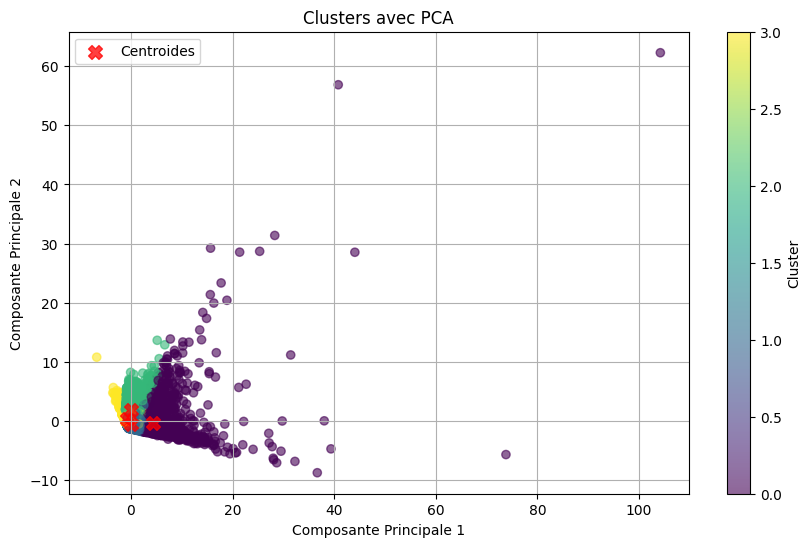

In [28]:



# S√©lection des variables pertinentes pour le clustering
variables_pour_clustering = [
    'number_of_views_7m',
    'number_of_sessions_7m',
    'loyalty_score','total_purchase_value',
    'conversion_rate'
]

# Filtrage et normalisation des donn√©es
X = df[variables_pour_clustering].dropna()
X_scaled = StandardScaler().fit_transform(X)

# Application du K-means avec le nombre optimal de clusters (par exemple 4)
k_optimal = 4
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
df['Cluster'] = clusters

# Calcul et affichage de l'Inertie et du Silhouette Score
print(f"Inertia : {kmeans.inertia_}")
print(f"Silhouette Score : {silhouette_score(X_scaled, clusters):.2f}")

# Visualisation des clusters avec PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Transformation des centro√Ødes avec la m√™me PCA utilis√©e sur les donn√©es
centroids = pca.transform(kmeans.cluster_centers_)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.6)

# Ajout des centro√Ødes correctement plac√©s
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=100, alpha=0.75, marker='X', label='Centroides')

plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.title('Clusters avec PCA')
plt.colorbar(scatter, label='Cluster')
plt.legend()
plt.grid(True)
plt.show()



## Interpr√©tation des Relations entre les Variables

Ensemble, PC1 et PC2 expliquent environ 55.4% de la variance totale des donn√©es, ce qui signifie que ces deux axes capturent une grande partie de l'information contenue dans les variables d'origine.


`number_of_sessions_7m et total_purchase_value` :

Ces deux variables sont **assez proches**, ce qui sugg√®re qu'elles sont positivement corr√©l√©es. Cela signifie que les clients qui ont un nombre √©lev√© de sessions tendent √©galement √† avoir une valeur totale d'achat √©lev√©e.

`avg_price_7m` :

Cette variable est orient√©e dans une direction distincte, mais est relativement proche de total_purchase_value, ce qui pourrait indiquer une certaine corr√©lation positive avec la valeur totale des achats, bien que moins forte que number_of_sessions_7m.

`brand_loyalty` :

Cette variable est orient√©e presque √† l'oppos√© des autres variables, surtout par rapport √† number_of_sessions_7m et total_purchase_value, ce qui sugg√®re une corr√©lation n√©gative. Cela pourrait indiquer que **les utilisateurs plus fid√®les √† une marque ne sont pas n√©cessairement ceux qui effectuent le plus d'achats ou qui ont le plus de sessions**.

`days_since_last_purchase` :

Cette variable est orient√©e vers le centre, ce qui indique qu'elle n'est pas fortement corr√©l√©e avec les autres variables dans cet espace. Cela sugg√®re que **le temps √©coul√© depuis le dernier achat est une mesure ind√©pendante de l'engagement utilisateur ou des habitudes d'achat**.


**Conclusion :**

Le cercle de corr√©lation montre clairement quelles variables sont les plus corr√©l√©es et comment elles se comportent par rapport aux composantes principales. Cela vous aide √† comprendre la structure sous-jacente des donn√©es et √† identifier les variables les plus influentes dans l'analyse (`number_of_sessions_7m`, `avg_price_7m`, `total_purchase_value`)

<div style="border: 1px solid #B0E0E6; padding: 10px; background-color: #E0FFFF;"> 



√âtant donn√© que `brand_loyalty` et `days_since_last_purchase` sont moins bien repr√©sent√©es dans l'ACP, nous pouvons  les exclure du reste de l'analyse de mani√®re √† nous concentrer sur les dimensions principales du comportement utilisateur. Ces variables semblent ne pas apporter beaucoup d'information suppl√©mentaire dans des mod√®les qui cherchent √† expliquer les comportements ou √† segmenter les utilisateurs.
</div>

In [33]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Supposons que df soit votre DataFrame contenant les donn√©es e-Amazing
# S√©lection des variables pertinentes pour le clustering
# variables_pour_clustering = [
#    # 'number_of_views_7m',
#    # 'number_of_carts_7m',
#    # 'number_of_sessions_7m',
#     # 'avg_price_7m',
#     # 'total_purchase_value',
#    # 'days_since_last_purchase',
#    # 'cart_abandonments',
#     'total_purchase_value', 
#     'number_of_views_7m',
#     #'count_products_7m', 
#     #'number_of_carts_7m',  
#     'number_of_sessions_7m' 
#    #'avg_session_duration'
# ]
variables_pour_clustering = [
    'number_of_sessions_7m',
    'loyalty_score',
    'total_purchase_value',
    'conversion_rate'
]

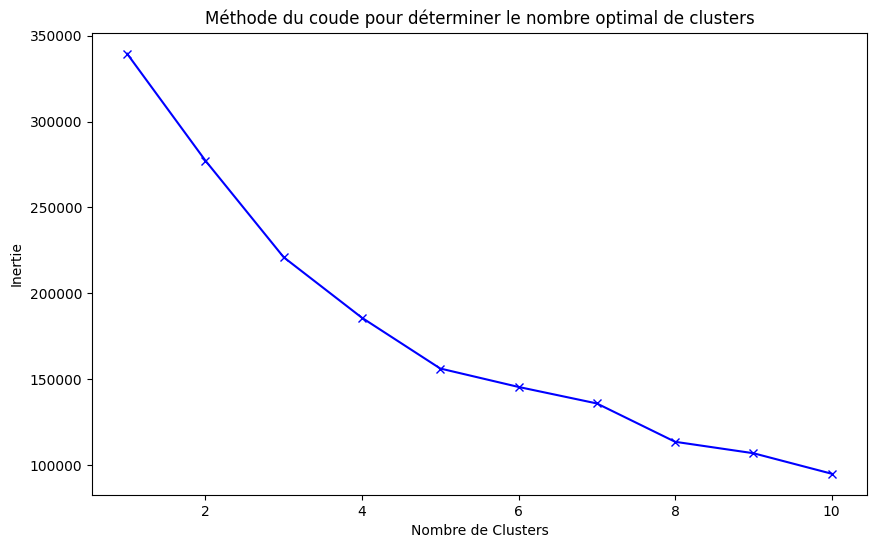

In [34]:

# Filtrer le DataFrame pour ne garder que ces variables
X = df[variables_pour_clustering]

# Suppression des lignes avec des valeurs manquantes
X = X.dropna()

# Normalisation des donn√©es
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# D√©termination du nombre optimal de clusters avec la m√©thode du coude (Elbow Method)
sse = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, 'bx-')
plt.xlabel('Nombre de Clusters')
plt.ylabel('Inertie')
plt.title('M√©thode du coude pour d√©terminer le nombre optimal de clusters')
plt.show()

D'apr√®s le graphique de la m√©thode du coude **(Elbow Method)**, le nombre optimal de clusters est d√©termin√© au point o√π l'inertie commence √† diminuer de mani√®re moins significative, indiquant une am√©lioration significative de la qualit√© du regroupement (formant un coude dans la courbe).  Ici, le coude semble se situer autour de 4 clusters.

La r√©duction de l'inertie devient plus faible √† chaque ajout de cluster suppl√©mentaire, sugg√©rant que les gains suppl√©mentaires ne justifient pas l'augmentation de la complexit√© du mod√®le.

**D'o√π, le choix optimal semble √™tre de  4 clusters pour param√©trer le K-means, car il repr√©sente un bon compromis entre complexit√© et efficacit√© du mod√®le.**

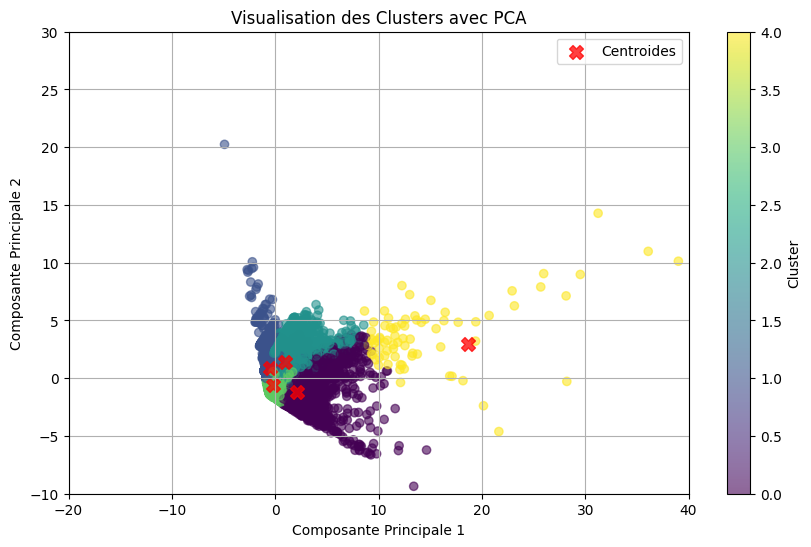

Silhouette Score : 0.43


In [35]:
# Choix du nombre de clusters 
k_optimal = 5
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Ajout des clusters au DataFrame original
df['Cluster'] = clusters



# Calcul et affichage du Silhouette Score
silhouette_avg = silhouette_score(X_scaled, clusters)


# Visualisation des clusters avec PCA (R√©duction de dimension pour la visualisation)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.6)

# Ajout des centro√Ødes des clusters avec taille r√©duite
centroids = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=100, alpha=0.75, marker='X', label='Centroides')

plt.title('Visualisation des Clusters avec PCA')
plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.colorbar(scatter, label='Cluster')
plt.legend()
plt.xlim(-20, 40)  # Ajustement des limites des axes pour ignorer les outliers extr√™mes
plt.ylim(-10, 30)
plt.grid(True)
plt.show()
print(f"Silhouette Score : {silhouette_avg:.2f}")


In [32]:
df['Cluster']

0        1
1        0
2        3
3        3
4        1
        ..
84859    1
84860    3
84861    3
84862    3
84863    1
Name: Cluster, Length: 84864, dtype: int32

### 1. Examiner les composantes principales et leurs contributions :

In [36]:
print("Variance expliqu√©e par chaque composante :", pca.explained_variance_ratio_)


Variance expliqu√©e par chaque composante : [0.35161461 0.27952897]


- Composante principale 1 (CP1) : 35,16% de la variance est expliqu√©e par cette composante.

- Composante principale 2 (CP2) : 27,95% de la variance est expliqu√©e par cette composante.

Ainsi, ces deux composantes capturent ensemble environ **63,11%** de la variance des donn√©es. Cela signifie que les deux premi√®res composantes principales sont assez repr√©sentatives des diff√©rences entre les utilisateurs, mais il reste 36,89% de la variance qui n'est pas expliqu√©e par ces deux dimensions.

### 2. Analyser les coefficients des composantes principales :

In [37]:
pca_components = pd.DataFrame(pca.components_, columns=variables_pour_clustering)
print(pca_components)


   number_of_sessions_7m  loyalty_score  total_purchase_value  conversion_rate
0               0.635513       0.310259              0.688609        -0.160249
1              -0.386990       0.564203              0.261393         0.680872


### 3. Interpr√©ter les clusters sur les deux premi√®res composantes principales :


    - Composante principale 1 (CP1) :

Les variables qui ont la plus grande influence positive sur cette composante sont total_purchase_value (0.688) et number_of_sessions_7m (0.636). Cela sugg√®re que la CP1 est fortement li√©e √† l'engagement des utilisateurs et √† la valeur totale des achats.
Les utilisateurs avec des scores √©lev√©s sur la CP1 sont donc des utilisateurs avec **beaucoup de sessions et une valeur totale d'achat √©lev√©e**.

    - Composante principale 2 (CP2) :

Les variables dominantes dans la CP2 sont conversion_rate (0.681) et loyalty_score (0.564). La CP2 semble donc capturer les aspects li√©s √† la fid√©lit√© et au taux de conversion.
Les utilisateurs avec des scores √©lev√©s sur la CP2 sont ceux qui ont **un taux de conversion √©lev√© et un score de fid√©lit√© √©lev√©**.

### 4. Calculer les moyennes des variables par cluster :


In [38]:
cluster_means = df.groupby('Cluster')[variables_pour_clustering].mean()
print(cluster_means)


         number_of_sessions_7m  loyalty_score  total_purchase_value  \
Cluster                                                               
0                   104.705598      66.097296           4338.160204   
1                     9.203715      58.580636            821.745567   
2                    14.415565     296.801620           3426.090670   
3                    16.442886      54.052630            533.145687   
4                   293.261905     194.197214          92787.338810   

         conversion_rate  
Cluster                   
0               0.377852  
1               0.939509  
2               0.497749  
3               0.341738  
4               0.720125  





#### **Cluster 0 :**  Fourmi üêú  ‚Üí Beaucoup de sessions, mais conversion et valeur d'achat mod√©r√©es.
- **Nombre de sessions moyen** : 104.7 (relativement √©lev√©)
- **Score de fid√©lit√©** : 66.1 (mod√©r√©)
- **Valeur totale des achats** : 4338.16 (mod√©r√©e)
- **Taux de conversion** : 0.377 (plut√¥t faible)

Ce groupe pourrait repr√©senter des **"Clients Actifs Mod√©r√©s"**. Ils ont un nombre de sessions √©lev√©, mais leur taux de conversion est relativement bas. Leur valeur totale d'achat est mod√©r√©e, ce qui indique qu'ils sont actifs mais ne convertissent pas autant que les autres.

#### **Cluster 1 :**  Faucon ü¶Ö ‚Üí Peu de sessions, conversion tr√®s √©lev√©e.
- **Nombre de sessions moyen** : 9.2 (tr√®s faible)
- **Score de fid√©lit√©** : 58.6 (faible)
- **Valeur totale des achats** : 821.7 (tr√®s faible)
- **Taux de conversion** : 0.939 (√©lev√©)

Ce groupe pourrait √™tre appel√© les **"Acheteurs Rapides"**. Bien qu'ils aient un faible nombre de sessions et une faible fid√©lit√©, leur taux de conversion est tr√®s √©lev√©, ce qui signifie qu'ils sont efficaces pour convertir leurs visites en achats, mais ne reviennent pas souvent.

#### **Cluster 2 :**  Castor ü¶´  ‚Üí Score de fid√©lit√© tr√®s √©lev√©, mais sessions et d√©penses mod√©r√©es.
- **Nombre de sessions moyen** : 14.4 (faible)
- **Score de fid√©lit√©** : 296.8 (tr√®s √©lev√©)
- **Valeur totale des achats** : 3426.1 (mod√©r√©e)
- **Taux de conversion** : 0.497 (moyen)

Ce groupe pourrait repr√©senter des **"Clients Fid√®les Mod√©r√©s"**. Ils ont un score de fid√©lit√© tr√®s √©lev√©, bien qu'ils aient un faible nombre de sessions et une valeur totale des achats mod√©r√©e. Leur taux de conversion est √©galement moyen, ce qui indique qu'ils reviennent souvent mais ne d√©pensent pas √©norm√©ment.

#### **Cluster 3 :**  Chenille üêõ  ‚Üí Faible activit√©, faible engagement et faible conversion
- **Nombre de sessions moyen** : 16.4 (faible)
- **Score de fid√©lit√©** : 54.1 (faible)
- **Valeur totale des achats** : 533.1 (tr√®s faible)
- **Taux de conversion** : 0.341 (faible)

Ce groupe pourrait √™tre qualifi√© d'**"Explorateurs Passifs"**. Ils ont un faible nombre de sessions, une faible fid√©lit√© et une faible valeur d'achat. Leur taux de conversion est √©galement bas, ce qui signifie qu'ils visitent le site mais ne sont pas enclins √† acheter.

#### **Cluster 4 :**  Lion ü¶Å ‚Üí Utilisateurs tr√®s engag√©s avec un score de fid√©lit√©, un nombre de sessions, et une valeur d'achat tr√®s √©lev√©s.
- **Nombre de sessions moyen** : 293.3 (tr√®s √©lev√©)
- **Score de fid√©lit√©** : 194.2 (tr√®s √©lev√©)
- **Valeur totale des achats** : 92787.3 (tr√®s √©lev√©e)
- **Taux de conversion** : 0.720 (√©lev√©)

Ce groupe est clairement compos√© des **"Super Utilisateurs"**. Ils ont un nombre de sessions tr√®s √©lev√©, un score de fid√©lit√© important, une valeur d'achat tr√®s √©lev√©e, et un bon taux de conversion. Ils repr√©sentent les clients les plus pr√©cieux du point de vue de l'engagement et des d√©penses.

<div style="border: 1px solid #B0E0E6; padding: 10px; background-color: #E0FFFF;"> 

L'ACP et les moyennes des variables nous permettent de bien diff√©rencier les comportements des clusters.
Nous pouvons maintenant utiliser ces interpr√©tations pour segmenter nos utilisateurs de mani√®re plus strat√©gique et ajuster nos actions marketing en cons√©quence. En comprenant mieux le comportement de chaque groupe, nous serons en mesure de personnaliser nos campagnes marketing, am√©liorer l'engagement des utilisateurs et optimiser nos offres. Par exemple, nous pourrons encourager les **"Explorateurs Passifs"** √† s'engager davantage, proposer des offres exclusives aux **"Super Utilisateurs"**, et stimuler la conversion des **"Clients Fid√®les Mod√©r√©s"** en leur proposant des incitations personnalis√©es. Cette segmentation nous permettra √©galement de mieux allouer nos ressources et d'am√©liorer la rentabilit√© globale en ciblant les bons utilisateurs avec les bons messages.
<div>